In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader,random_split # önemli kütüphanelerin import edilmesi
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
from torchvision import models
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # GPU kontrolü

transform = transforms.Compose(
    [transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]) # Resimin ImageNet Standartlarında normalize edilmesi

In [2]:
PATH = '../input/EEGIMAGEPSD'

data = datasets.ImageFolder(PATH, transform = transform) # dataset oluşturulması
print(data)
np.random.seed(42)

train_size = int(0.70 * len(data)) # istenilen oranda datasetin train/test şeklinde bölünmesi
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])
print(f"Dataset has {len(data)} data points.")
print(f"Train Dataset has {len(train_dataset)} data points")
print(f"Test Dataset has {len(test_dataset)} data points.") 

Dataset ImageFolder
    Number of datapoints: 14895
    Root location: ../input/EEGIMAGEPSD
Dataset has 14895 data points.
Train Dataset has 10426 data points
Test Dataset has 4469 data points.


In [3]:
###HYPERPARAMETERS###
batch_size = 8
num_epochs = 10
learning_rate = 0.0003
###HYPERPARAMETERS###

In [4]:
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)

test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(401408, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

    
model = Net()
model.to(device)
#Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
import time
print_every = len(train_loader) - 1
loss_values = []
start_time = time.time()
total_step = len(train_loader)
epoch_times = []
total_step = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader): ###TRAİNİNG_LOOP
        epoch_start_time = time.time()
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i+1) % print_every == 0:
            epoch_times.append(time.time() - epoch_start_time)
            loss_values.append(running_loss / print_every)
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}: Batch Loss : {}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), running_loss / print_every))
            running_loss = 0
end_of_training = time.time() - start_time

arr_pred = np.empty((0,len(test_dataset)), int)

arr_label = np.empty((0,len(test_dataset)), int)

with torch.no_grad(): 
    correct = 0
    total = 0
    for images, labels in test_loader:  #PREDİCTİON LOOP
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred = predicted.cpu().numpy()
        lb = labels.cpu().numpy()
        arr_pred = np.append(arr_pred, pred)
        arr_label = np.append(arr_label, lb)
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/10], Step [1303/1304], Loss: 0.4141: Batch Loss : 1.0393676563056724
Epoch [2/10], Step [1303/1304], Loss: 0.3705: Batch Loss : 0.5418108356680581
Epoch [3/10], Step [1303/1304], Loss: 0.1852: Batch Loss : 0.46644306944501646
Epoch [4/10], Step [1303/1304], Loss: 0.2461: Batch Loss : 0.40504477583072046
Epoch [5/10], Step [1303/1304], Loss: 0.6683: Batch Loss : 0.36888895896838797
Epoch [6/10], Step [1303/1304], Loss: 0.1330: Batch Loss : 0.3430479269757787
Epoch [7/10], Step [1303/1304], Loss: 0.2579: Batch Loss : 0.3239719383961772
Epoch [8/10], Step [1303/1304], Loss: 0.0772: Batch Loss : 0.29270632491830856
Epoch [9/10], Step [1303/1304], Loss: 0.7600: Batch Loss : 0.28662670196154805
Epoch [10/10], Step [1303/1304], Loss: 0.0927: Batch Loss : 0.2653215857578623
Test Accuracy of the model on the 10000 test images: 88.2971582009398 %


In [7]:
x_axis = np.arange(1,num_epochs + 1)

def find_interval_for_graph(end_of_training, num_epochs):
    interval = end_of_training / num_epochs
    return interval
interval = find_interval_for_graph(end_of_training, num_epochs)
x_interval_axis = np.arange(0, end_of_training, interval)

print(f"Total Training Time : {end_of_training / 60} dk")

Total Training Time : 38.51147125959396 dk


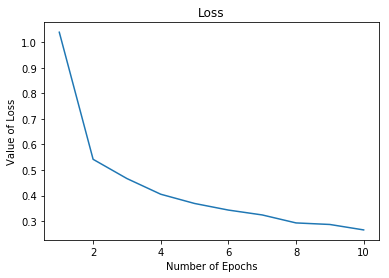

In [8]:
import matplotlib.pyplot as plt 

plt.title("Loss")
plt.ylabel("Value of Loss")
plt.xlabel("Number of Epochs")
plt.plot(x_axis, loss_values)

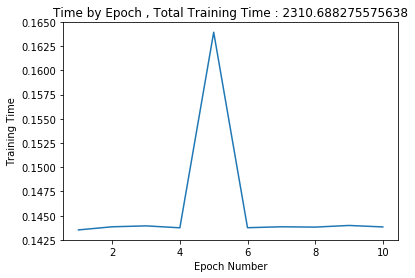

In [9]:
plt.title("Time by Epoch , Total Training Time : {}".format(end_of_training))
plt.ylabel("Training Time")
plt.xlabel("Epoch Number")
print(plt.plot(x_axis,epoch_times))

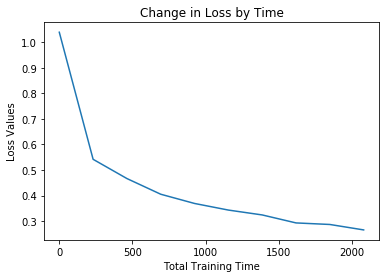

In [10]:
plt.title("Change in Loss by Time")
plt.ylabel("Loss Values")
plt.xlabel("Total Training Time")
plt.plot(x_interval_axis, loss_values)

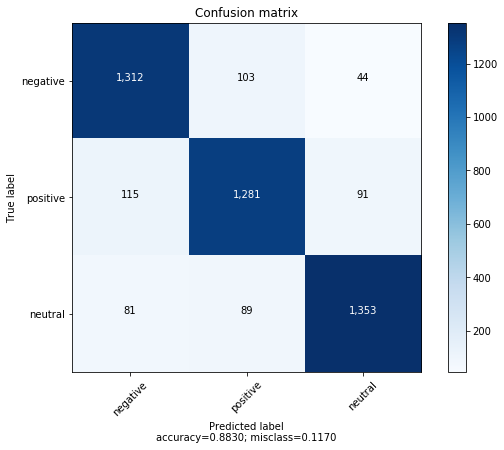

The Accuracy : 88.2971582009398
The Precision : 88.29848288560332
The Recall : 88.30300996228094
The F1 Score : 88.28801005299027


In [11]:
from sklearn import metrics
from cm_helper import plot_confusion_matrix
cm = metrics.confusion_matrix(arr_label, arr_pred)
plot_confusion_matrix(cm, target_names= ["negative", "positive", "neutral"], title='Confusion matrix' , normalize= False)

print(f"The Accuracy : { 100 * metrics.accuracy_score(arr_label, arr_pred)}")
print(f"The Precision : {100 * metrics.precision_score(arr_label, arr_pred, average= 'macro')}")
print(f"The Recall : {100 * metrics.recall_score(arr_label, arr_pred, average= 'macro')}")
print(f"The F1 Score : {100 *metrics.f1_score(arr_label, arr_pred, average = 'macro')}")